In [1]:
import os
os.chdir('..')

In [27]:
import torch
import pickle
import numpy as np

from gnn_library.util import load
from evaluate import evaluate_model
from instance_generator import sample_instances
from params import *
from util import _box_plots, graph_config_to_string

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
print("PyTorch has version {}".format(torch.__version__))
print('Using device:', device)

GNN, args = load('GNN2_hyperparam_tuned', device)

PyTorch has version 2.0.0+cu117
Using device: cuda:2


In [ ]:
# Hyperparam optimized for 10,6

# args = {
#     'processor':         'GENConv',
#     'head':              'regression',     
#     'num_layers':        3,
#     'num_mlp_layers':    3,
#     'aggr':              'max',
#     'batch_size':        8,
#     'node_feature_dim':  5,
#     'edge_feature_dim':  1,
#     'graph_feature_dim': 2,
#     'hidden_dim':        32,
#     'output_dim':        1,
#     'dropout':           0.0306,
#     'epochs':            64,
#     'opt':               'adagrad',
#     'opt_scheduler':     'none',
#     'opt_restart':       0,
#     'weight_decay':      5e-3,
#     'lr':                0.0121,
#     'device':            device,
#     'noise':             0 # Set to 0 to not train on noisy features
# }

# train_loader, val_loader = gen_train_input(BASE_MODEL_TRAIN_CONFIG, args, seed=0)
# _, _, _, GNN, _ = train(train_loader, val_loader, args)

## Box plot baseline evaluation

In [32]:
rng = np.random.default_rng(seed=0)
num_trials = 2#40
batch_size = 500
node_configs = EXPERIMENT_BASE_TESTING_REGIMES
graph_configs = MAIN_TESTING_GRAPH_CONFIGS
baselines_kwargs = {
    'greedy': {},
    'greedy_t': {'threshold': 0.35},
    'lp_rounding': {}
}

data = {node_config: {} for node_config in node_configs}

for node_config in node_configs:
    for graph_config in graph_configs:
            print(node_config, graph_config)
            instances = sample_instances(
                *node_config,
                num_trials,
                rng,
                args.__dict__,
                **graph_config
            )

            cr_ratios, _ = evaluate_model(
                meta_model=None,
                meta_model_type=None,
                base_models=[GNN],
                instances=instances,
                batch_size=batch_size,
                rng=rng,
                num_realizations=5,
                baselines=['greedy', 'greedy_t', 'lp_rounding'],
                **baselines_kwargs
            )

            data[node_config][str(graph_config)] = cr_ratios


(30, 10) {'graph_type': 'ER', 'p': 0.5, 'weighted': True}
(30, 10) {'graph_type': 'GEOM', 'q': 0.25, 'd': 2, 'weighted': True}
(30, 10) {'graph_type': 'OSMNX', 'location': 'Fremont, California, USA'}
(30, 10) {'graph_type': 'GM'}


In [33]:
results = {}
for graph_type, val in data[EXPERIMENT_BASE_TESTING_REGIMES[0]].items():
	results[graph_type] = val

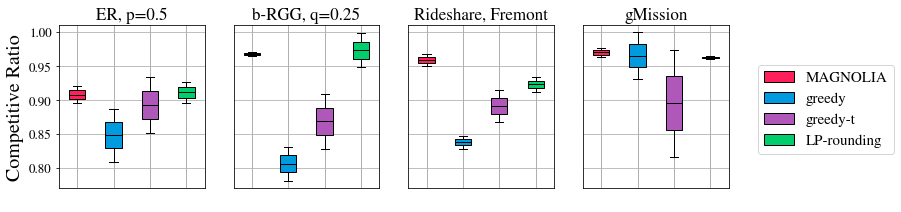

In [34]:
from util import _box_plots
_box_plots(results, lambda graph_type: f"GNN2_classify_{graph_type} {node_config[1]}x{node_config[0]}")